In [1]:
import numpy as np
import math # trigonometry, pi
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import re # function string parsing

## Mathematical Expressions and derivative
### (Simple to understand, non optimised)

In [3]:
class Expr:
    pass

In [64]:
class Const(Expr):
    """Constant
    example: 5"""
    def __init__(self, val):
        self.val = val
    
    def __str__(self):
        if self.val == math.pi:
            return "pi"
        elif self.val == math.e:
            return "e"
        return str(self.val)
    
    def eval(self, env=None):
        return self.val
    
    def der(self, respect_to=None):
        return Const(0)

In [5]:
class Var(Expr):
    """Variable
    example: x"""
    def __init__(self, name):
        self.name = name
    
    def __str__(self):
        return self.name
    
    def eval(self, env):
        return env[self.name]
    
    def der(self, respect_to=None):
        if not respect_to is None and respect_to != self.name:
            return Const(0)
        else:
            return Const(1)

In [6]:
class Add(Expr):
    """Addition"""
    def __init__(self, left, right):
        self.left = left
        self.right = right
            
    def __str__(self):
        return "(" + str(self.left) + " + " + str(self.right) + ")"
    
    def eval(self, env):
        return self.left.eval(env) + self.right.eval(env)
    
    def der(self, respect_to=None):
        return Add(self.left.der(respect_to), self.right.der(respect_to))

In [7]:
class Sub(Expr):
    """Substraction"""
    def __init__(self, left, right):
        self.left = left
        self.right = right
    
    def __str__(self):
        return "(" + str(self.left) + " - " + str(self.right) + ")"
    
    def eval(self, env):
        return self.left.eval(env) - self.right.eval(env)
    
    def der(self, respect_to=None):
        return Sub(self.left.der(respect_to), self.right.der(respect_to))

In [8]:
class Mul(Expr):
    """Multiplication"""
    def __init__(self, left, right):
        self.left = left
        self.right = right
        
    def __str__(self):
        return "(" + str(self.left) + " * " + str(self.right) + ")"
    
    def eval(self, env):
        return self.left.eval(env) * self.right.eval(env)
    
    def der(self, respect_to=None):
        return Add(Mul(self.left.der(respect_to), self.right),
                    Mul(self.left, self.right.der(respect_to)))

In [9]:
class Div(Expr):
    """Division"""
    def __init__(self, left, right):
        self.left = left
        self.right = right
        
    def __str__(self):
        return "(" + str(self.left) + " / " + str(self.right) + ")"
    
    def eval(self, env):
        return self.left.eval(env) / self.right.eval(env)
    
    def der(self, respect_to=None):
        return Div(Sub(Mul(self.left.der(respect_to), self.right),
                        Mul(self.left, self.right.der(respect_to))),
                      Mul(self.right, self.right))

In [10]:
class Quad(Expr):
    """Quadratic equations
    ex: x^2"""
    def __init__(self, var, power):
        self.var = var
        self.power = power
    
    def __str__(self):
        return str(self.var) + " ^ " + str(self.power)
    
    def eval(self, env):
        return self.var.eval(env) ** self.power.eval(env)
    
    def der(self, respect_to=None):
        return Mul(Mul(Const(self.power.eval()), self.var.der(respect_to)),
                    Quad(self.var, Const(self.power.eval() - 1)))

In [11]:
class Exp(Expr):
    """Exponential
    example: e^x"""
    def __init__(self, base, power):
        self.base = base
        self.power = power
        
    def __str__(self):
        if isinstance(self.base, Const) and self.base.eval() == math.e:
            return "e" + " ^ " + str(self.power)
        return str(self.base) + " ^ " + str(self.power)
    
    def eval(self, env):
        return np.power(self.base.eval(env), self.power.eval(env))
    
    def der(self, respect_to=None):
        return Mul(Mul(self, Log(self.base)), self.power.der(respect_to))

In [12]:
###### Tetration (not finished)
class Tet(Exp):
    """Tetration
    example: x^x"""
    pass

In [13]:
class Qet(Expr):
    """An intermediatery class
    Using this to decide whether an expression is Quad, Exp or Tet"""
    pass

In [96]:
class Log(Expr):
    """Logarithms
    example: ln(x), log10(x)"""
    def __init__(self, x, base=Const(math.e)):
        self.x = x
        self.base = base
    
    def __str__(self):
        if isinstance(self.base, Const) and self.base.eval() == math.e:
            return "ln(" + str(self.x) + ")"
        return "log" + str(self.base) + "(" + str(self.x) + ")"
    
    def eval(self, env):
        return math.log(self.x.eval(env), self.base.eval(env)) 
    
    def der(self, respect_to=None):
        return Div(self.x.der(respect_to),
                   Mul(self.x, Log(self.base)))

In [97]:
class Sin(Expr):
    """Sinus"""
    def __init__(self, x):
        self.x = x
        
    def __str__(self):
        return "sin(" + str(self.x) + ")"
    
    def eval(self, env):
        return np.sin(self.x.eval(env))
    
    def der(self, respect_to=None):
        return Mul(Cos(self.x), self.x.der(respect_to))

In [98]:
class Cos(Expr):
    """Cosinus"""
    def __init__(self, x):
        self.x = x
        
    def __str__(self):
        return "cos(" + str(self.x) + ")"
    
    def eval(self, env):
        return np.cos(self.x.eval(env))
    
    def der(self, respect_to=None):
        return Mul(Const(-1), Mul(Sin(self.x), self.x.der(respect_to)))

In [99]:
class Tan(Expr):
    """Tangent"""
    def __init__(self, x):
        self.x = x
        
    def __str__(self):
        return "tan(" + str(self.x) + ")"
    
    def eval(self, env):
        return np.tan(self.x.eval(env))
    
    def der(self, respect_to=None):
        return Div(self.x.der(respect_to),
                  Quad(Cos(self.x), Const(2)))

In [18]:
class Cot(Expr):
    """Cotangent"""
    def __init__(self, x):
        self.x = x
        
    def __str__(self):
        return "cot(" + str(self.x) + ")"
    
    def eval(self, env):
        return 1 / np.tan(self.x.eval(env))
    
    def der(self, respect_to=None):
        return Div(Mul(Const(-1), self.x.der(respect_to)),
                  Quad(Sin(self.x), Const(2)))

## Mathematical Expressions with simplifying

### (Not finished)

In [68]:
class Expr:
    pass

In [69]:
class Const(Expr):
    """Constant
    example: 5"""
    def __init__(self, val):
        self.val = val
    
    def __str__(self):
        return str(self.val)
    
    def eval(self, env=None):
        return self.val
    
    def simplify(self):
        return self
    
    def der(self, respect_to=None):
        return Const(0)

In [70]:
class Var(Expr):
    """Variable
    example: x"""
    def __init__(self, name):
        self.name = name
    
    def __str__(self):
        return self.name
    
    def eval(self, env):
        return env[self.name]
    
    def simplify(self):
        return self
    
    def der(self, respect_to=None):
        if not respect_to is None and respect_to != self.name:
            return Const(0)
        else:
            return Const(1)

In [71]:
class Add(Expr):
    """Addition"""
    def __init__(self, left, right):
        self.left = left
        self.right = right
            
    def __str__(self):
        return "(" + str(self.left) + " + " + str(self.right) + ")"
    
    def eval(self, env):
        return self.left.eval(env) + self.right.eval(env)
    
    def simplify(self):
        if isinstance(self.left, Const) and self.left.eval() == 0:
            return self.right
        elif isinstance(self.right, Const) and self.right.eval() == 0:
            return self.left
        return self
    
    def der(self, respect_to=None):
        left = self.left.der(respect_to)
        right = self.right.der(respect_to)
        return Add(left.simplify(), right.simplify()).simplify()

In [77]:
expr = Add(Var("x"), Const(1))
print(expr)

(x + 1)


In [78]:
# returns 1 instead of (1 + 0)
print(expr.der())

1


### Helper Functions

In [19]:
def factorial(n):
    """Factorial of the given integer"""
    f = 1
    for i in range(2, n+1):
        f *= i
    return f

In [20]:
def taylor_expr(expr, a=0, order=5):
    """Find taylor series of a given expression
    
    Parameters
    ----------
    expr: expression of function (class Expr)
    a: point which taylor series will be found
    order: order of taylor series
        (increase order to increase precision)
    
    Return
    ------
    expr: taylor series (class Expr)"""
    # g(x) = from n=0 to order: sum(f'nth(a) * ((x - a) ** n) / n!)
    env = {"x": a}
    # zeroth order
    taylor_func = Const(expr.eval(env))
    deriv = expr.der()
    # for higher orders than zeroth
    for n in range(1, order + 1):
        temp_expr = Div(Mul(Const(deriv.eval(env)), 
                            Quad(Sub(Var("x"), Const(a)), Const(n))), 
                        Const(factorial(n)))
        taylor_func = Add(taylor_func, temp_expr)
        deriv = deriv.der()
        
    return taylor_func

In [21]:
def jacobian(expr, variables):
    """Calculate jacobian vector of an expression
    respect to variables
    
    Parameters
    ----------
    expr: expression (function)
        that belongs to Expr class
    variables: list of variables to take derivatives
        ie. ["x", "y", "z"]"""
    j = [0] * len(variables)
    for i, v in enumerate(variables):
        j[i] = expr.der(v)
    
    return j

#### plotting

In [22]:
def plot_expr(expr, interval, return_results=False):
    """Plots an expression by using matplotlib
    
    Parameters
    ----------
    expr: an expression class
    interval: interval of function for plotting
    return_results: if true returns interval and results list"""
    var = "x"
    interval = list(interval)
    #vals = list(map(lambda x: expr.eval({var: x}), interval))
    vals = [0 for _ in interval]
    i = 0
    while i < len(interval):
        # if function is undefined at that point,
        # dont take it to result
        try:
            val = expr.eval({var: interval[i]})
            vals[i] = val
            i += 1
        except:
            del vals[i]
            del interval[i]
        
    # plotting
    plt.figure()
    xmin, xmax = interval[0], interval[-1]
    ymin, ymax = min(vals), max(vals)
    #plt.xlim((xmin, xmax))
    #plt.ylim((ymin, ymax))
    plt.hlines(y=0, xmin=xmin, xmax=xmax)
    plt.vlines(x=0, ymin=ymin, ymax=ymax)
    plt.xlabel(var)
    plt.ylabel("y")
    plt.title("f(" + var + ")" + " = " + str(expr))
    plt.plot(interval, vals)
    
    if return_results:
        return interval, vals

In [23]:
def plot_expr_2(expr, interval, return_results=False):
    """Plots an expression by using matplotlib
    Crops undefined or extremely big or small parts"""
    

### Math Expressions Test

In [208]:
#Sin(x^2)
expr = Sin(Quad(Var("x"), Const(2)))
print(expr)

sin(x ^ 2)


In [209]:
print(expr.der())

(cos(x ^ 2) * ((2 * 1) * x ^ 1))


<IPython.core.display.Javascript object>


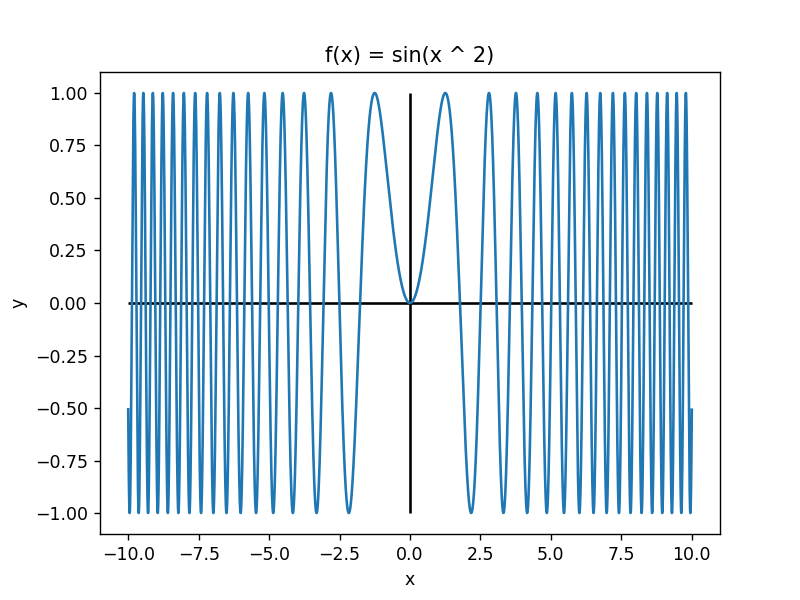

In [210]:
plot_expr(expr, np.arange(-10, 10, 0.0001))

In [214]:
mul = Mul(Var("x"), Var("x"))
print(mul)

(x * x)


In [215]:
#numpy computation is so fast

In [216]:
interval = np.arange(-100000, 100000, 0.1)

In [217]:
%%time
mul.eval({"x": interval})

Wall time: 6.91 ms


array([1.00000e+10, 9.99998e+09, 9.99996e+09, ..., 9.99994e+09,
       9.99996e+09, 9.99998e+09])

In [218]:
%%time
for i in interval:
    mul.eval({"x": i})

Wall time: 1.82 s


### Parsing Functions

In [24]:
def get_precedence(operator):
    """gets precedence of an operator"""
    if operator == Qet:
        return 2
    elif operator == Mul or operator == Div:
        return 1
    elif operator == Add or operator == Sub:
        return 0
    return -1

In [25]:
def find_closing_par(expr, i):
    """finds right boundary paranthesis
    
    Parameters:
    expr: expression string
    i: index of openning paranthesis
    
    returns: index of closing paranthesis"""
    depth = 0
    while i < len(expr):
        if expr[i] == "(":
            depth += 1
        elif expr[i] == ")":
            depth -= 1
        
        if depth == 0:
            return i
        i += 1
        
    if depth != 0:
        return None
    return i-1 # len(expr)-1

In [26]:
def decide_qet(expr, left, right):
    """Decides whether an expression object is Quad, Exp or Tet
    
    Parameters:
    expr: Expr class
    left and right: left and right parts of the expression
    
    Returns:
    New decided expression object"""
    if isinstance(left, Const) and isinstance(right, Const):
        return Const(left.eval() ** right.eval())
    elif isinstance(right, Const):
        return Quad(left, right)
    elif isinstance(left, Const):
        return Exp(left, right)
    else:
        return Tet(left, right)

In [31]:
def get_number(expr, i):
    """finds continuous number in expression starting at index i
    
    Returns:
    number: number consists of continuous digits
    end: index of last digit of number
    
    ex: inputs -> expr = 'log10(x)', i = 3
        outputs -> number = 10, end = 5"""
    start = i
    i += 1
    while i<len(expr) and (expr[i].isdigit() or expr[i] == "."):
        i += 1
    end = i - 1
    
    if "." in expr[start:end+1]:
        return float(expr[start:end+1]), end
    else:
        return int(expr[start:end+1]), end

In [32]:
def parse(postfix):
    """Parses postfix expressions list into an expression object

    Parameters:
    postfix: postfix expressions list

    Returns:
    final expression object"""
    stack = []
    operators = {Add, Sub, Mul, Div, Qet}
    
    for expr in postfix:
        if expr in operators:
            second = stack.pop()
            first = stack.pop()
            if expr == Qet:
                stack.append(decide_qet(expr, first, second))
            else:
                stack.append(expr(first, second))
        else:
            stack.append(expr)
    
    return stack.pop()

In [66]:
def infix_to_postfix(expr):
    """converts from infix to postfix
    
    Parameters:
    expr: mathematical expression string
    
    Returns:
    Postfix expressions list"""
    output = []
    stack = []
    # initialization lists
    func_letters = {"a", "c", "i", "g", "l", "n", "o", "s", "t"}
    functions = {"sin": Sin, "cos": Cos, "tan": Tan, "cot": Cot, "log": Log}
    operators = {"+": Add, "-": Sub, "*": Mul, "/": Div, "^": Qet}
    #digits = set([str(i) for i in range(0, 10)])
    
    i = 0
    while i < len(expr):
        # number parsing
        ####################### Add support for double numbers (like 3.14)
        if expr[i].isdigit():
            num, i = get_number(expr, i)
            output.append(Const(num))
            
        # operators
        elif expr[i] in operators:
            while stack and get_precedence(operators[expr[i]]) <= get_precedence(stack[-1]):
                output.append(stack.pop())
            stack.append(operators[expr[i]])
            
        # paranthesis
        elif expr[i] == "(":
            stack.append("(")
        elif expr[i] == ")":
            while stack and stack[-1] != "(":
                output.append(stack.pop())
            if not stack:
                print("Paranthesis missing")
                break
            stack.pop()
            
        # variables
        elif expr[i] == "x":
            output.append(Var("x"))
            
        # functions
        elif expr[i] in func_letters:
            func_string = expr[i:i+3]
            if func_string in functions:
                
                # logarithm parsing
                if func_string == "log":
                    base, i = get_number(expr, i+3)
                    closing_par = find_closing_par(expr, i+1)
                    parsed = parse(infix_to_postfix(expr[i+2:closing_par]))
                    func = Log(parsed, Const(base))
                    output.append(func)
                    i = closing_par
                    
                # other functions
                else:
                    closing_par = find_closing_par(expr, i+3)
                    parsed = parse(infix_to_postfix(expr[i+4:closing_par]))
                    func = functions[func_string](parsed)
                    output.append(func)
                    i = closing_par
                    
            # ln parsing
            elif func_string[:2] == "ln":
                closing_par = find_closing_par(expr, i+2)
                parsed = parse(infix_to_postfix(expr[i+3:closing_par]))
                func = Log(parsed)
                output.append(func)
                i = closing_par
        
        # special defined numbers (e, pi)
        elif expr[i] == "e" or expr[i] == "p":
            if expr[i] == "e":
                output.append(Const(math.e))
            elif expr[i:i+2] == "pi":
                output.append(Const(math.pi))
                i += 1
                
        # space character
        else:
            pass
        
        i+=1
    
    # extract all remaining operators
    while stack:
        output.append(stack.pop())
    
    return output

In [67]:
def get_parsed(expr):
    """gets parsed expression object from a mathematical expression string"""
    return parse(infix_to_postfix(expr))

### Tests

In [68]:
#1
expr = parse(infix_to_postfix("5+x^2"))

In [69]:
print(expr)

(5 + x ^ 2)


In [70]:
expr.eval({"x": 3})

14

In [71]:
#2
print(parse(infix_to_postfix("(5+(3-2)*4)")))

(5 + ((3 - 2) * 4))


In [72]:
#3
expr = parse(infix_to_postfix("cos(x^2)"))

In [73]:
print(expr)

cos(x ^ 2)


In [74]:
#4
expr = parse(infix_to_postfix("sin(x)^2 + cos(x)^2"))

In [75]:
print(expr)

(sin(x) ^ 2 + cos(x) ^ 2)


In [76]:
expr.eval({"x":-343434343})

1.0

In [77]:
#5
expr = parse(infix_to_postfix("x * 2 ^ 5"))

In [78]:
print(expr)

(x * 32)


In [100]:
#6
expr = parse(infix_to_postfix("3+log8(64*x)"))

In [101]:
print(expr)

(3 + log8((64 * x)))


In [102]:
expr.eval({"x":1})

5.0

In [103]:
#7
expr = get_parsed("ln(x)*x")

In [104]:
print(expr)

(ln(x) * x)


<IPython.core.display.Javascript object>


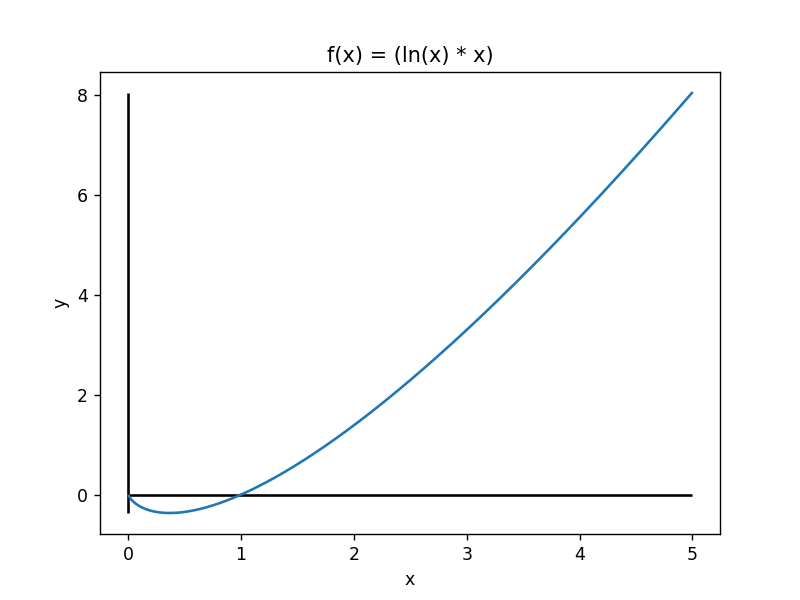

In [105]:
plot_expr(expr, np.arange(0, 5, (5-0)/1000))

In [106]:
#8
expr = get_parsed("ln(x)*(x*ln(x*27))*5+(7869-x^(log1818(x^2)))")

In [107]:
print(expr)

(((ln(x) * (x * ln((x * 27)))) * 5) + (7869 - x ^ log1818(x ^ 2)))


In [108]:
%%timeit
get_parsed("ln(x)*(x*ln(x*27))*5+(7869-x^(log1818(x^2)))")

95.5 µs ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [109]:
%%time
for i in range(8000):
    get_parsed("ln(x)*(x*ln(x*27))*5+(7869-x^(log1818(x^2)))")

Wall time: 752 ms


In [118]:
#9
expr = get_parsed("x^(0.5) + 9.87")

In [119]:
print(expr)

(x ^ 0.5 + 9.87)


In [121]:
expr.eval({"x": 4})

11.87

### ADD HANDLING NEGATİVE EXPRESSİONS

In [125]:
#10
expr = get_parsed("-1*-5")

IndexError: pop from empty list

In [126]:
#11
# an expression of a solution for a differential function
expr = get_parsed("(1/(e^(9*x)))*(cos(4.359*x) + 0.688*sin(4.359*x))")

In [127]:
print(expr)

((1 / e ^ (9 * x)) * (cos((4.359 * x)) + (0.688 * sin((4.359 * x)))))


<IPython.core.display.Javascript object>


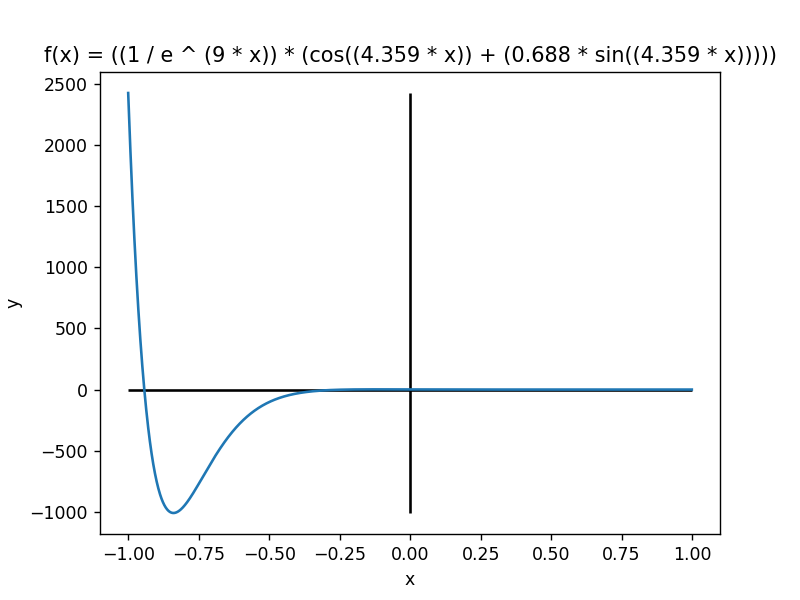

In [136]:
plot_expr(expr, np.arange(-1, 1, 0.001))

### Visualization

In [3]:
# splitting np array by a value
inf = float("inf")

a = np.array([1, 2, 3, inf, 3, 5, inf, 9, inf, inf, 8, 10])

splitted = np.split(a, np.where(a == inf)[0])
splitted

[array([1., 2., 3.]),
 array([inf,  3.,  5.]),
 array([inf,  9.]),
 array([inf]),
 array([inf,  8., 10.])]

### Forward things

In [101]:
lst = [i for i in range(1, int(1e4))]
lst_np = np.array(lst)

In [102]:
# normal
def normal(lst):
    for i in lst:
        i ** 2

In [103]:
%%time
normal(lst)

Wall time: 4 ms


In [104]:
# numpy
def rec(lst, s, e):
    if s == e:
        lst[s] ** 2
        return None
    else:
        lst[s:e+1] ** 2
        m = (s + e) // 2
        rec(lst, s, m)
        rec(lst, m+1, e)

In [105]:
%%time
rec(lst_np, 0, len(lst_np)-1)

Wall time: 28 ms


In [106]:
%%time
lst_np ** 2

Wall time: 0 ns


array([       1,        4,        9, ..., 99940009, 99960004, 99980001],
      dtype=int32)